In [0]:
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
import torchvision

dataset = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=torchvision.transforms.ToTensor()
)
label=[]

for i in range(0,len(dataset)):
  if i==0:
    image, _ = dataset[i]
    label.append(dataset[i][1])
    
  elif dataset[i][1]!=label[-1]:
    image=torch.cat((image, dataset[i][0]), dim=0)
    label.append(dataset[i][1])

label0=[]
for i in range(0, 1000):
  if i==0:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  elif dataset[i+1][1]!=label0[-1]:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  if len(label0)>=1000-len(label):
    break


x_test=image.numpy()
label=np.array(label)
label0=np.array(label0)
y_test=np.concatenate((label, label0),axis=None)

import cv2
x_test_res=[]
for i in range(0,len(x_test)):
  x_test_res.append(cv2.resize(x_test[i], (32,32)))
x_test_res=np.array(x_test_res)

x_test_1=np.ones((1000, 32,32,3))
for k in range(0, x_test_1.shape[0]):
  for i in range(0,32):
    for j in range(0,32):
      for l in range(0,3):
        x_test_1[k][i][j][l]=1-x_test_res[k][i][j]


Files already downloaded and verified


In [0]:
x_test=(x_test_1 * 255).astype('int')

In [0]:
x_test = x_test.reshape((x_test.shape[0], 3, 32, 32))
x_test = x_test.astype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


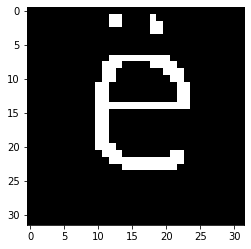

In [19]:
plt.imshow(x_test[1].reshape(32,32,3))

In [20]:
from keras.datasets import cifar10

(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

x_train_cifar = x_train_cifar.reshape((x_train_cifar.shape[0], 3, 32, 32))
x_test_cifar = x_test_cifar.reshape((x_test_cifar.shape[0], 3, 32, 32))
y_train_cifar = y_train_cifar.reshape(-1)
y_test_cifar = y_test_cifar.reshape(-1)

#Get only first 1000 pictures for test
x_test_cifar=x_test_cifar[:1000]
y_test_cifar=y_test_cifar[:1000]

x_train_cifar = x_train_cifar.astype('float32')
x_test_cifar = x_test_cifar.astype('float32')
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train_cifar.shape, y_train_cifar.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test_cifar.shape, y_test_cifar.shape))

batch = 64

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step
[cifar] x_train.shape=(50000, 3, 32, 32), y_train.shape=(50000,)
[cifar] x_test.shape=(1000, 3, 32, 32), y_test.shape=(1000,)


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(), ])

trainloader_cifar = torch.utils.data.DataLoader(x_train_cifar, batch_size=batch,
                                          shuffle=True, num_workers=2)

testloader_cifar = torch.utils.data.DataLoader(x_test, batch_size=batch,
                                          shuffle=False, num_workers=2)

In [0]:
def train_cifar(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
 
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()
        for i, inputs_cifar in enumerate(trainload):
          
            img = Variable(inputs_cifar).to(device)
            _, outputs_cifar = net(img)
            loss = criterion(outputs_cifar, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            
            if verbose and i % 750 == 749:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 750))
                running_loss = 0.0

        running_loss_val = 0.0
        net.eval()
        for i, data in enumerate(testloader):

            images = data  
            images = Variable(images).to(device)
            decoded_imgs = net(images)[1]
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

            if verbose and i % 15 == 14:
                print('[%d, %5d] val_loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_val / 15))
                running_loss_val = 0.0
        print("============================")
        if scheduler is not None:
            scheduler.step()
    end= time.time()
    print(f"Time cost for training (in seconds): {end-start} ")

In [0]:
class Autoencoder3_2D(nn.Module):
    def __init__(self):
        super(Autoencoder3_2D, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=5),
                        nn.BatchNorm2d(32),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),

                        nn.Conv2d(32, 64, kernel_size=5),
                        nn.BatchNorm2d(64),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),


                        nn.Conv2d(64, 128, kernel_size=5),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),

                        nn.Conv2d(128, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),

                        nn.Conv2d(256, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(

                        #nn.MaxUnpool2d(kernel_size=2),
                        nn.ConvTranspose2d(256, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),

                        nn.ConvTranspose2d(256, 128, kernel_size=5),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),

                        nn.ConvTranspose2d(128, 64, kernel_size=5),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),

                        #nn.MaxUnpool2d(kernel_size=2, stride=2),
                        nn.ConvTranspose2d(64, 32, kernel_size=5),
                        nn.ReLU(True),
                        # nn.Dropout2d(p),
                        
                        nn.ConvTranspose2d(32, 3, kernel_size=5),
                        nn.ReLU(True))
                        

        
    def forward(self,x):
        x_out = self.decoder(self.encoder(x))
        
        return _, x_out

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 100
autoencoder_cifar2D = Autoencoder3_2D().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder_cifar2D.parameters(), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
train_cifar(epochs, autoencoder_cifar2D, criterion, optimizer, trainloader_cifar, testloader_cifar,  scheduler=scheduler, verbose=True)

[1,   750] loss: 3068.748
[1,    15] val_loss: 3742.700
[2,   750] loss: 1507.457
[2,    15] val_loss: 2534.820
[3,   750] loss: 817.410
[3,    15] val_loss: 2216.388
[4,   750] loss: 613.154
[4,    15] val_loss: 2036.422
[5,   750] loss: 482.679
[5,    15] val_loss: 1874.801
[6,   750] loss: 422.264
[6,    15] val_loss: 1559.490
[7,   750] loss: 346.267
[7,    15] val_loss: 1875.455
[8,   750] loss: 315.357
[8,    15] val_loss: 1424.601
[9,   750] loss: 279.743
[9,    15] val_loss: 1317.801
[10,   750] loss: 253.054
[10,    15] val_loss: 1524.594
[11,   750] loss: 234.057
[11,    15] val_loss: 1213.806
[12,   750] loss: 209.758
[12,    15] val_loss: 1165.041
[13,   750] loss: 192.448
[13,    15] val_loss: 1026.287
[14,   750] loss: 189.345
[14,    15] val_loss: 1143.761
[15,   750] loss: 176.351
[15,    15] val_loss: 1055.425
[16,   750] loss: 162.432
[16,    15] val_loss: 941.497
[17,   750] loss: 156.453
[17,    15] val_loss: 868.497
[18,   750] loss: 146.140
[18,    15] val_loss: 8

In [0]:
running_loss_val = 0.0
i = 0
decoded_pics = []
reconstruction_time = []

test_loader = torch.utils.data.DataLoader(x_test, batch_size=1, shuffle=False, num_workers=2)

with torch.no_grad():
    for data in test_loader:
        images = data  
        images = Variable(images).to(device)
        i += 1
        encoded_imgs = autoencoder_cifar2D.encoder(images)
        start=time.time()
        decoded_imgs = autoencoder_cifar2D.decoder(encoded_imgs)
        end=time.time()
        reconstruction_time.append((end-start))
        decoded_pics.append(decoded_imgs)
        loss_val = criterion(decoded_imgs, images)
        running_loss_val += loss_val.data

In [26]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the tunned CNN AE on the 1000 test OMNIGLOT images trained on CIFAR10: {running_loss_val/i}')
print(f"Decoding time {mean} is measured in seconds per sample")

MSE of the tunned CNN AE on the 1000 test OMNIGLOT images trained on CIFAR10: 269.47650146484375
Decoding time 0.0005861868858337403 is measured in seconds per sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0, 0.5, '$CNN_2$')

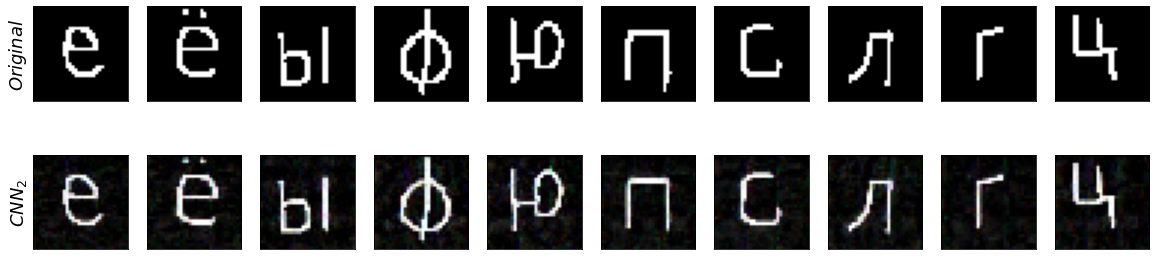

In [28]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

for X_test in testloader_cifar:
  for i in range(10):
      im = X_test[i,:]
      ax[0, i].imshow(im.numpy().reshape(32, 32, 3));
      ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(32, 32, 3).astype(int))
      ax[0, i].get_xaxis().set_ticks([])
      ax[0, i].get_yaxis().set_ticks([])
      ax[1, i].get_xaxis().set_ticks([])
      ax[1, i].get_yaxis().set_ticks([])


  break
ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
ax[1, 0].set_ylabel(f"$CNN_2$",fontsize=18)